# INTRODUCTION

# Defining the problem

### A broad definition of fashion is the preferred style of clothing at a given moment. Time, which can relate to the four seasons, different fashion eras, or even different fashion trends and choices, profoundly influences changes in fashion. Older styles may resurface as the newest trends under the umbrella term "fashion," which we are utilizing in this context.

### While conducting an in-depth study of all fashion data, data quality and quantity may be a limiting constraint. In order to make this project more accessible to and understandable by the general public, we will use a smaller and more broadly defined set of fashion data. Despite the material's maybe poor quality and quantity, seeing it from a wider perspective makes it much easier to understand.

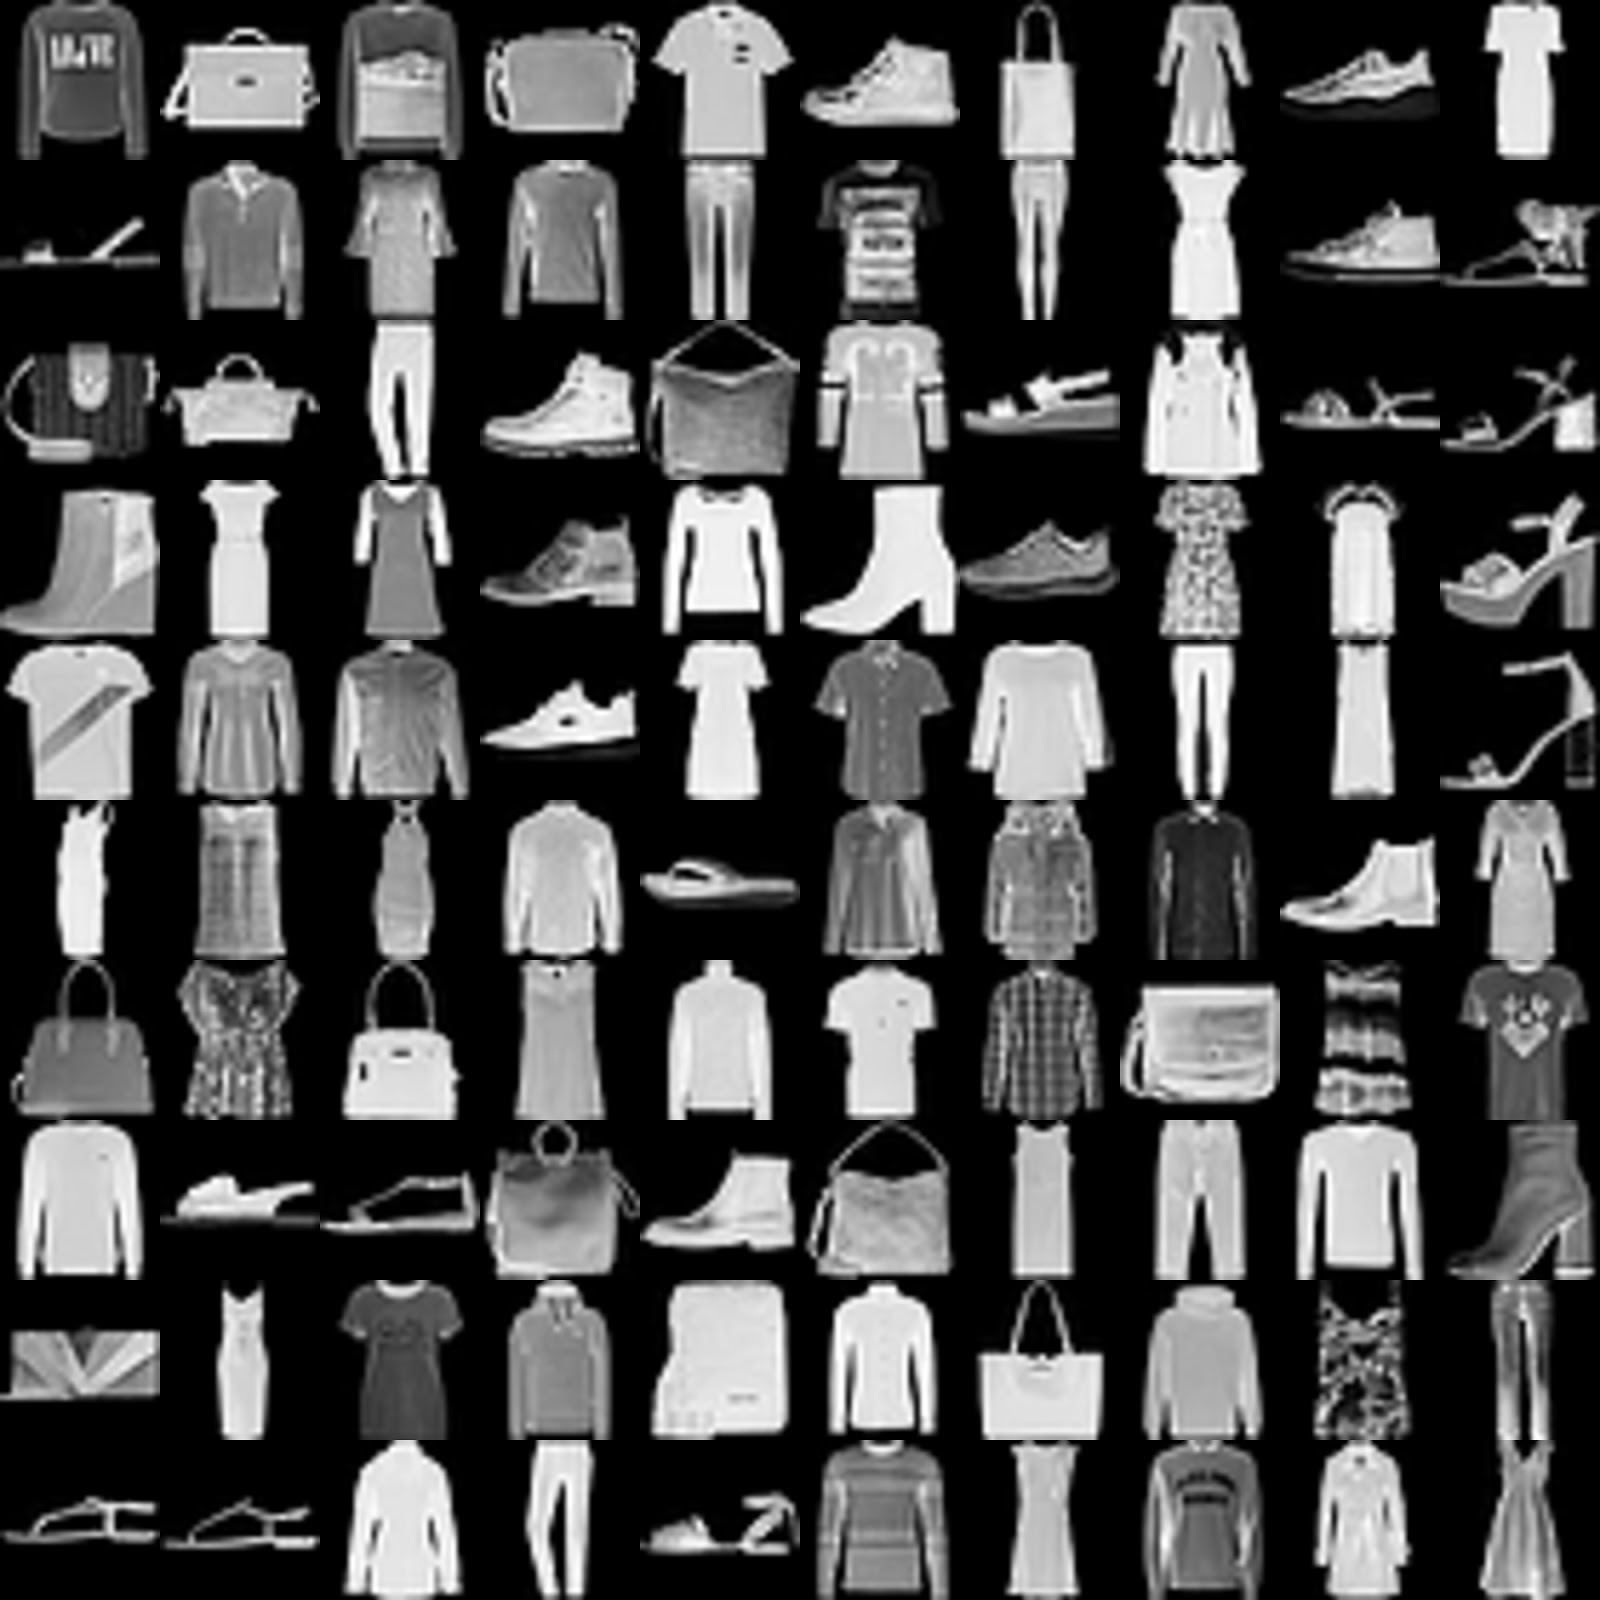

###  Figure 1: Images of FASHION MNIST dataset. (http://marubon-ds.blogspot.com/2017/09/fashion-mnist-exploring.html)

# Data quality

###  The fashion MNIST dataset is a well-known benchmark dataset in the machine learning community, often used for image classification tasks. It is simple to work with the photos because they have already been normalized and pre-processed to have a pixel value range between 0 and 1. The dataset is balanced as well, with an equal number of images for each of the 10 categories of clothing. This makes sure that the model is not biased towards any particular class. The FASHION MNIST dataset is also well-labeled, with accurate and consistent labels for each image. 

# Data quantity

### The FASHION MNIST dataset is a collection of 70,000 grayscale images of clothing items, each with a size of 28x28 pixels.The dataset is evenly split into 60,000 training images and 10,000 test images, and each image is assigned one of 10 possible classes representing different types of clothing items. However, given the limitations of the labels and the dataset utilized, it is possible that not all types of apparel are represented in the dataset. 

### Overall, the dataset provides a good amount of data for training and evaluating machine learning models designed to recognize and classify clothing items based on their visual appearance.

# Assembling the Dataset

### For this project, we will utilize a TensorFlow dataset known as fashion MNIST, which is distinct from the datasets referenced in the given Coursework Instructions (MNIST, Reuters, IMDB, and Boston Housing Price).

### Using this dataset, we will make predictions about the category of fashion apparel that an image depicts. For instance, 'coat' is represented by a label of class 4 while 'pullover' is represented by class 4, as depicted below. Furthermore, the dataset is a single-label, multiclass classification, implying that we will utilize softmax for the last-layer activation and calculate the loss function using 'categorical_crossentropy.'

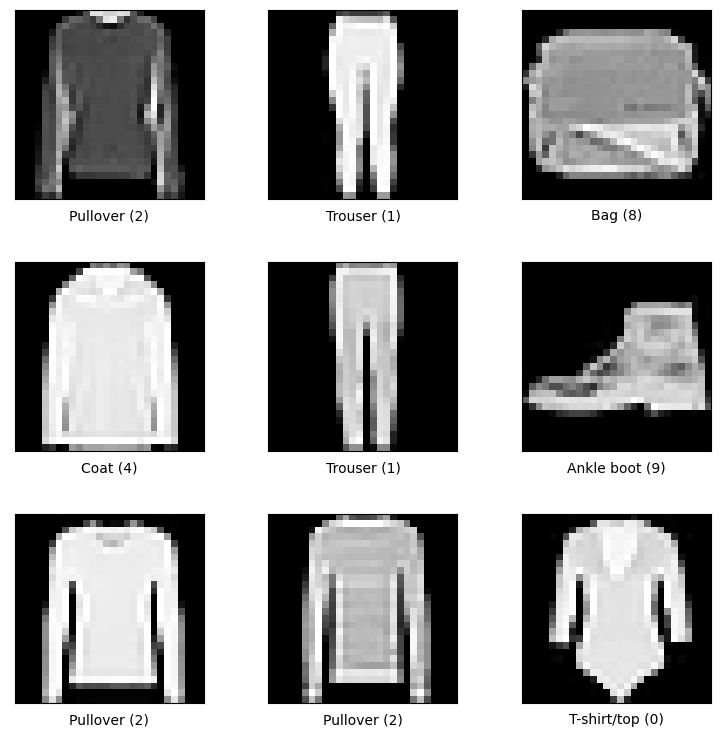

In [1]:
import tensorflow_datasets as tfds

dataset, ds_info = tfds.load('fashion_mnist',split='train',with_info=True) 
fig = tfds.show_examples(dataset,ds_info)


### Once the required libraries have been imported for the project, we utilize the TensorFlow library to import the dataset. This includes pre-separated train and test sets. We would further split the dataset into test, train, and validation sets in the ratios of 1:3:1 respectively since we would need to train our models on training and validation sets.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
DATASET_SIZE = 60000
TEST_RATIO = 0.2
TRAIN_RATIO = 0.6
VALIDATION_RATIO = 0.2


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

# Split the dataset into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=2021)

# Further split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VALIDATION_RATIO/(1-TEST_RATIO), random_state=2021)


### This shows how the labels and images from the fashion mnist split dataset are organized. To make sure that this data can be fed into a machine-learning model, we would need to pre-process them.

In [4]:
datasets = {'X_test': X_test, 'y_test': y_test, 'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

for name, data in datasets.items():
    print(f'Shape of {name}: Rows - {data.shape[0]}, Columns - {data.shape[1:3]}')


Shape of X_test: Rows - 14000, Columns - (28, 28)
Shape of y_test: Rows - 14000, Columns - ()
Shape of X_train: Rows - 42000, Columns - (28, 28)
Shape of y_train: Rows - 42000, Columns - ()
Shape of X_val: Rows - 14000, Columns - (28, 28)
Shape of y_val: Rows - 14000, Columns - ()


# Baseline 


### We will create our initial baseline using the data in its current format before preparing it.



### By integrating the validation and training data, we can use the code we produced earlier to identify the label that appears in the training data the most frequently. We will then find the estimated probability of correctly predicting the label by using the code as shown below. 

### This baseline is determined by using instances from the dataset, and it greatly depends on how the dataset is divided. We will dive further into another baseline example at Baseline 1.2 below.

In [5]:
total_test = np.zeros(10)
total_train = np.zeros(10)
total_y_train = np.concatenate([y_train, y_val])

for label in total_y_train:
    total_train[label] += 1

for label in y_test:
    total_test[label] += 1

# print the number of samples for each class
print("Total number of samples for each class in training set:", total_train)
print("Total number of samples for each class in test set:", total_test)

# print most freq label
most_frequent_label = np.argmax(total_train)
# print accuracy
accuracy = (total_test[most_frequent_label] / np.sum(y_test)) * 100
print(f"Most frequent label: {most_frequent_label}")
print(f"Percentage of accuracy using probability model: {accuracy}")

Total number of samples for each class in training set: [5589. 5599. 5566. 5628. 5619. 5611. 5605. 5599. 5591. 5593.]
Total number of samples for each class in test set: [1411. 1401. 1434. 1372. 1381. 1389. 1395. 1401. 1409. 1407.]
Most frequent label: 3
Percentage of accuracy using probability model: 2.178953721055808


# Preparing the Data

### We will have to prepare the data so that it can be used by the model.
### Firstly, we will reshape the array.
### Secondly, we will cast it as floats and rescale them.
### Lastly, we will one-hot encode using to_categorical where each label is converted into a 10-element vector of zeros with the exception of one.


In [6]:
# Reshape the arrays
reshaped_datasets = [dataset.reshape(-1, 28*28) for dataset in [X_train, X_test, X_val]]

# Cast as floats and rescale 
scaled_datasets = [dataset.astype('float32') / 255 for dataset in reshaped_datasets]

# Assign the reshaped and scaled datasets back to their original variables
X_train, X_test, X_val = scaled_datasets


In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [8]:
datasets = {'X_test': X_test, 'y_test': y_test, 'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

for name, data in datasets.items():
    print(f'Shape of {name}: {data.shape[0]}, {data.shape[1]} ')

Shape of X_test: 14000, 784 
Shape of y_test: 14000, 10 
Shape of X_train: 42000, 784 
Shape of y_train: 42000, 10 
Shape of X_val: 14000, 784 
Shape of y_val: 14000, 10 


# Optimizer

### Adam will serve as our optimizer for this project because it combines the finest qualities of AdaGrad, RMSprop, and momentum. Also, Adam consistently out performs other adaptive approaches and is effective for training deep learning models.

# Loss vs Accuracy

### In order to be employed later on in the project when developing a model, we have functions that carry out the action of plotting the loss and accuracy. This is so that we can make sure the model is operating as precisely as possible by analyzing both graphs.

### Since we have the same number of samples per label or class, accuracy will be a relevant parameter for our compilation. This is due to the fact that accuracy depends on the quantity of samples available. But, when we split the data into test, validation, and training sets, the number of samples per label or class is no longer the same. 

### Hence, to guarantee the best possible performance of the model, it is necessary to plot the accuracy and loss graphs during the model building and improvement process to assess whether the model is under-fitting, over-fitting, or achieving a good fit.

In [9]:
def plot_loss(loss, val_loss):
    '''plot training loss and validation loss on the graph'''
    # clear any existing figures
    plt.clf()  
    # get number of epochs
    epochs = range(1, len(loss) + 1)  
    
    # plot training loss with red dashed line and circle marker
    plt.plot(epochs, loss, 'r--o', label="Training Loss")
    # plot validation loss with blue solid line and square marker
    plt.plot(epochs, val_loss, 'bs-', label="Validation Loss")
    
    # set a title of graph and labels of each axis
    plt.title("Training Loss & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def plot_accuracy(acc, val_acc):
    '''plot training accuracy and validation accuracy'''
    # clear any existing figures
    plt.clf()  
    # get number of epochs
    epochs = range(1, len(acc)+1)  
    
    # plot training accuracy with green dashed line and circle marker
    plt.plot(epochs, acc, 'g--o', label="Training Accuracy")
    # plot validation accuracy with purple solid line and square marker
    plt.plot(epochs, val_acc, 'ms-', label="Validation Accuracy")
    
    # set a title of graph and labels of each axis
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


# The Hold-Out Evaluation protocol

### For our models, the hold-out protocol is typically sufficient. Hence, we'll start by attempting to build a model using the hold-out validation.

# Underfit Model

### The first model would be rather straightforward and would meet the minimal criteria necessary for statistical power, which is to have an accuracy higher than 0.1. We will only require the loss function "categorical_crossentropy" and the last activation layer "softmax".

In [11]:
# Define an empty network
underfit_model = tf.keras.models.Sequential()

In [12]:
# add dense layer
underfit_model.add(tf.keras.layers.Dense(10,activation='softmax'))

In [13]:
# optimizer, loss and metrics are chosen at compilation
underfit_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
# training - fit to input data
underfit_result = underfit_model.fit(X_train,y_train,epochs=10,batch_size=128,validation_data=(X_val,y_val))

Epoch 1/10
329/329 [==============================] - 1s 2ms/step - loss: 0.8165 - accuracy: 0.7294 - val_loss: 0.5888 - val_accuracy: 0.8004
Epoch 2/10
329/329 [==============================] - 0s 1ms/step - loss: 0.5548 - accuracy: 0.8142 - val_loss: 0.5152 - val_accuracy: 0.8282
Epoch 3/10
329/329 [==============================] - 0s 1ms/step - loss: 0.5062 - accuracy: 0.8297 - val_loss: 0.4872 - val_accuracy: 0.8368
Epoch 4/10
329/329 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.8378 - val_loss: 0.4685 - val_accuracy: 0.8421
Epoch 5/10
329/329 [==============================] - 0s 1ms/step - loss: 0.4622 - accuracy: 0.8435 - val_loss: 0.4549 - val_accuracy: 0.8475
Epoch 6/10
329/329 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.8476 - val_loss: 0.4494 - val_accuracy: 0.8451
Epoch 7/10
329/329 [==============================] - 0s 1ms/step - loss: 0.4400 - accuracy: 0.8501 - val_loss: 0.4456 - val_accuracy: 0.8474
Epoch 

In [15]:
# print summary
underfit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


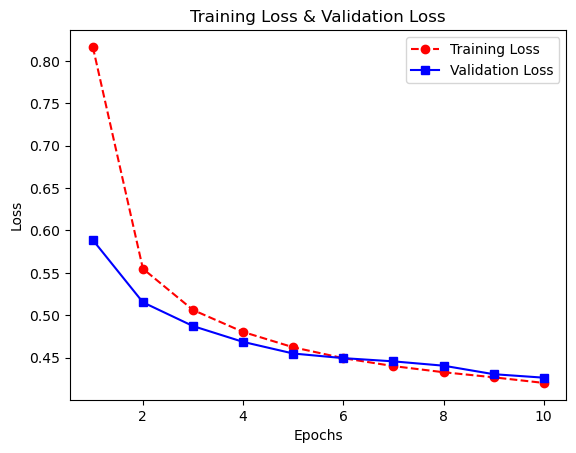

In [16]:
# plot loss graph
plot_loss(underfit_result.history['loss'],underfit_result.history['val_loss'])

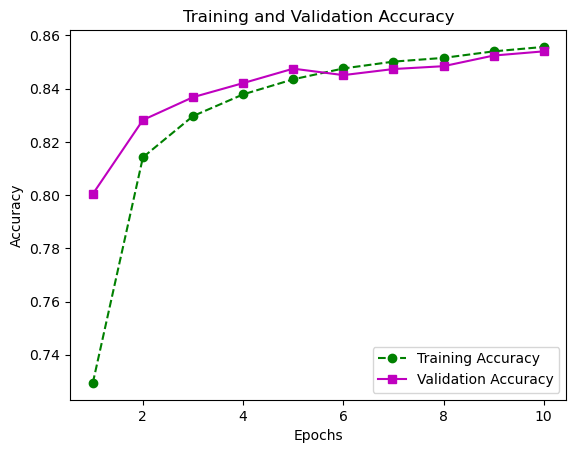

In [17]:
# plot accuracy graph
plot_accuracy(underfit_result.history['accuracy'],underfit_result.history['val_accuracy'])

In [18]:
evaluation = underfit_model.evaluate(X_val, y_val)
test_loss = evaluation[0]
test_acc = evaluation[1]

438/438 [==============================] - 0s 697us/step - loss: 0.4264 - accuracy: 0.8540


### Despite the underfitting model, our accuracy has a value of 85%, as illustrated below. This surpasses our baseline of 10%. We will move on to create a model that overfits.

# Overfit Model

### We must create a model that overfits after creating one that performs better than the baseline. We must now cross the line into overfitting as the purpose of this research is to design a model that balances between overfitting and underfitting.

### We can be sure that the overfitting model has been attained once the model's performance on the validation data begins to decline, and we either increase the model's size or the amount of training.

In [19]:
# Define an empty network
overfit_network = tf.keras.models.Sequential()

# Adding the layers to the network
overfit_network.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28*28,)))
overfit_network.add(tf.keras.layers.Dense(124, activation='relu'))
overfit_network.add(tf.keras.layers.Dense(46, activation='relu'))
overfit_network.add(tf.keras.layers.Dense(10, activation='softmax'))

In [20]:
# Compile the network
overfit_network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Training - Fit the model to the input data
overfit_result = overfit_network.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/40
657/657 [==============================] - 4s 6ms/step - loss: 0.5412 - accuracy: 0.8083 - val_loss: 0.4096 - val_accuracy: 0.8519
Epoch 2/40
657/657 [==============================] - 4s 6ms/step - loss: 0.3910 - accuracy: 0.8585 - val_loss: 0.3616 - val_accuracy: 0.8663
Epoch 3/40
657/657 [==============================] - 4s 6ms/step - loss: 0.3478 - accuracy: 0.8721 - val_loss: 0.3834 - val_accuracy: 0.8611
Epoch 4/40
657/657 [==============================] - 4s 6ms/step - loss: 0.3202 - accuracy: 0.8818 - val_loss: 0.3700 - val_accuracy: 0.8607
Epoch 5/40
657/657 [==============================] - 4s 6ms/step - loss: 0.3058 - accuracy: 0.8862 - val_loss: 0.3203 - val_accuracy: 0.8879
Epoch 6/40
657/657 [==============================] - 4s 6ms/step - loss: 0.2862 - accuracy: 0.8932 - val_loss: 0.3387 - val_accuracy: 0.8777
Epoch 7/40
657/657 [==============================] - 4s 6ms/step - loss: 0.2725 - accuracy: 0.8978 - val_loss: 0.3108 - val_accuracy: 0.8856
Epoch 

In [22]:
overfit_network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dense_2 (Dense)             (None, 124)               63612     
                                                                 
 dense_3 (Dense)             (None, 46)                5750      
                                                                 
 dense_4 (Dense)             (None, 10)                470       
                                                                 
Total params: 471,752
Trainable params: 471,752
Non-trainable params: 0
_________________________________________________________________


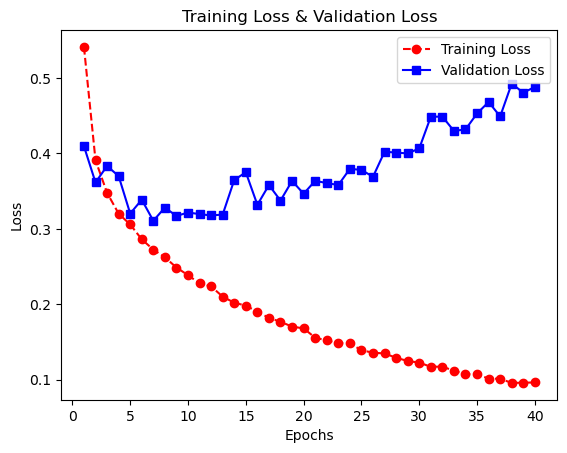

In [23]:
plot_loss(overfit_result.history['loss'],overfit_result.history['val_loss'])

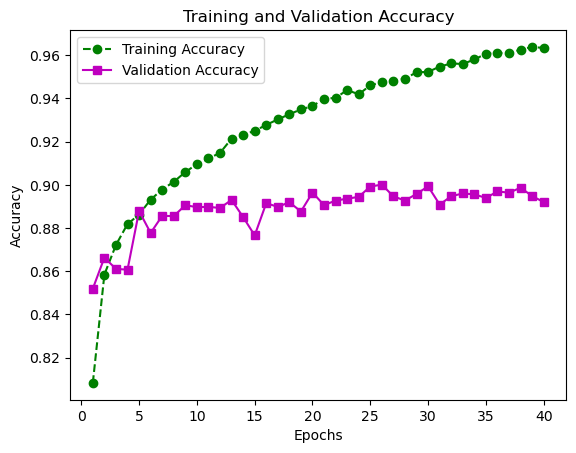

In [24]:
plot_accuracy(overfit_result.history['accuracy'],overfit_result.history['val_accuracy'])

In [25]:
# Evaluate the model on the validation data
evaluation = overfit_network.evaluate(X_val, y_val)
# Get the test loss and accuracy values
test_loss = evaluation[0]
test_acc = evaluation[1]

438/438 [==============================] - 1s 1ms/step - loss: 0.4882 - accuracy: 0.8920


### According to the evaluation above, the overfit model's accuracy is at 89%, which is greater than the underfit model's. Yet, as evidenced by the stark disparity between the training and validation loss and accuracy, the presented curve exhibits severe overfitting.

### After building an overfit model, we must tweak the model until the desired line is discovered. There are numerous ways to accomplish this and we will assess the network on the entire test set after the model is initialized.

# Regularising the Model using Drop Out

In [26]:
# Define an empty network
model_1  = tf.keras.models.Sequential()
# adding 2 layers
model_1.add(tf.keras.layers.Dense(512,activation='relu',input_shape=(28*28,)))
model_1.add(tf.keras.layers.Dropout(0.7))
model_1.add(tf.keras.layers.Dense(124,activation='relu'))
model_1.add(tf.keras.layers.Dense(46,activation='relu'))
model_1.add(tf.keras.layers.Dropout(0.7))
model_1.add(tf.keras.layers.Dense(10,activation='softmax'))

In [27]:
# optimizer, loss and metrics are chosen at compilation
model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
# Training - Fit the model to the input data
result_1 = model_1.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val))


Epoch 1/40
329/329 [==============================] - 3s 8ms/step - loss: 1.2668 - accuracy: 0.5320 - val_loss: 0.6125 - val_accuracy: 0.7639
Epoch 2/40
329/329 [==============================] - 2s 7ms/step - loss: 0.8464 - accuracy: 0.6861 - val_loss: 0.5510 - val_accuracy: 0.7964
Epoch 3/40
329/329 [==============================] - 2s 7ms/step - loss: 0.7676 - accuracy: 0.7223 - val_loss: 0.4969 - val_accuracy: 0.8086
Epoch 4/40
329/329 [==============================] - 2s 8ms/step - loss: 0.7148 - accuracy: 0.7417 - val_loss: 0.4791 - val_accuracy: 0.8314
Epoch 5/40
329/329 [==============================] - 3s 8ms/step - loss: 0.6824 - accuracy: 0.7598 - val_loss: 0.4513 - val_accuracy: 0.8359
Epoch 6/40
329/329 [==============================] - 2s 8ms/step - loss: 0.6545 - accuracy: 0.7682 - val_loss: 0.4478 - val_accuracy: 0.8434
Epoch 7/40
329/329 [==============================] - 2s 8ms/step - loss: 0.6487 - accuracy: 0.7761 - val_loss: 0.4299 - val_accuracy: 0.8443
Epoch 

In [29]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 124)               63612     
                                                                 
 dense_7 (Dense)             (None, 46)                5750      
                                                                 
 dropout_1 (Dropout)         (None, 46)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                470       
                                                                 
Total params: 471,752
Trainable params: 471,752
Non-tr

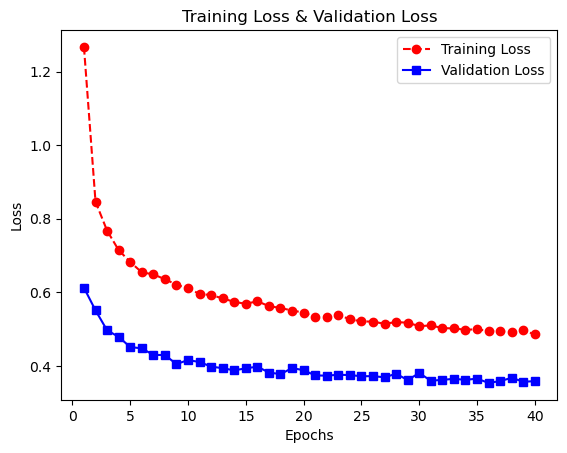

In [30]:
plot_loss(result_1.history['loss'],result_1.history['val_loss'])

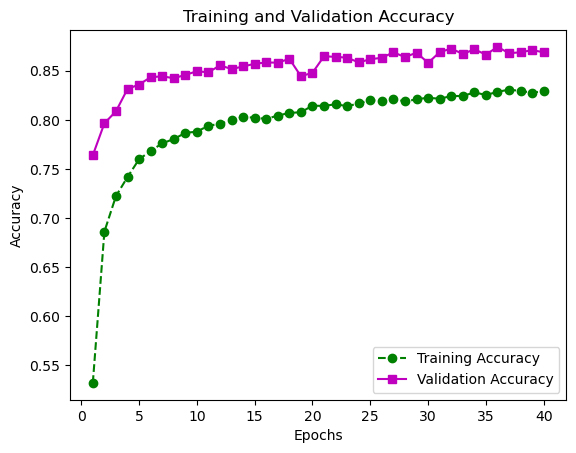

In [31]:
plot_accuracy(result_1.history['accuracy'],result_1.history['val_accuracy'])

In [32]:
test_loss,test_acc=model_1.evaluate(X_val,y_val)

438/438 [==============================] - 1s 1ms/step - loss: 0.3587 - accuracy: 0.8687


# Regularising the model using another method, L1 and/or L2 regularization

In [33]:
# Define an empty network
model_2 = tf.keras.models.Sequential()

# Adding the layers to the network
model_2.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28*28,)))
model_2.add(tf.keras.layers.Dense(124, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
model_2.add(tf.keras.layers.Dense(46, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_2.add(tf.keras.layers.Dense(10, activation='softmax'))


In [34]:
# Compile the model with chosen optimizer, loss, and metrics
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Fit the model to the training data
result_2 = model_2.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/40
329/329 [==============================] - 3s 8ms/step - loss: 4.9606 - accuracy: 0.7477 - val_loss: 1.1602 - val_accuracy: 0.7794
Epoch 2/40
329/329 [==============================] - 2s 7ms/step - loss: 0.9900 - accuracy: 0.8042 - val_loss: 0.8713 - val_accuracy: 0.8133
Epoch 3/40
329/329 [==============================] - 2s 7ms/step - loss: 0.8254 - accuracy: 0.8215 - val_loss: 0.7684 - val_accuracy: 0.8281
Epoch 4/40
329/329 [==============================] - 2s 7ms/step - loss: 0.7391 - accuracy: 0.8352 - val_loss: 0.7098 - val_accuracy: 0.8358
Epoch 5/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6909 - accuracy: 0.8406 - val_loss: 0.6914 - val_accuracy: 0.8345
Epoch 6/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6565 - accuracy: 0.8465 - val_loss: 0.6391 - val_accuracy: 0.8438
Epoch 7/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6289 - accuracy: 0.8507 - val_loss: 0.6257 - val_accuracy: 0.8482
Epoch 

In [36]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               401920    
                                                                 
 dense_10 (Dense)            (None, 124)               63612     
                                                                 
 dense_11 (Dense)            (None, 46)                5750      
                                                                 
 dense_12 (Dense)            (None, 10)                470       
                                                                 
Total params: 471,752
Trainable params: 471,752
Non-trainable params: 0
_________________________________________________________________


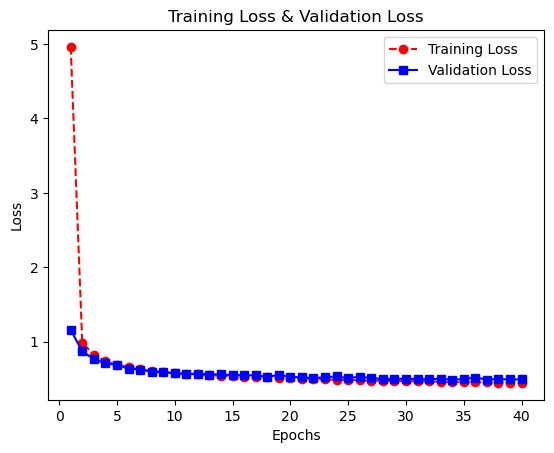

In [37]:
plot_loss(result_2.history['loss'],result_2.history['val_loss'])

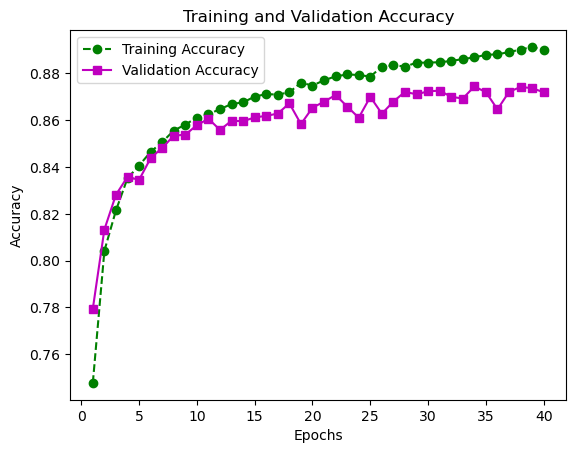

In [38]:
plot_accuracy(result_2.history['accuracy'],result_2.history['val_accuracy'])

In [39]:
test_loss,test_acc=model_2.evaluate(X_val,y_val)

438/438 [==============================] - 1s 1ms/step - loss: 0.4935 - accuracy: 0.8719


### Now we can combine the methods used above to achieve a good-fit for the model

In [40]:
# Define an empty network
model_3 = models.Sequential()

# adding 2 layers
model_3.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28*28,)))
model_3.add(tf.keras.layers.Dropout(0.7))
model_3.add(tf.keras.layers.Dense(124, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model_3.add(tf.keras.layers.Dense(46, activation='relu'))
model_3.add(tf.keras.layers.Dense(10, activation='softmax'))

In [41]:
# optimizer, loss and metrics are chosen at compilation
model_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [42]:
# Fit the model to the training data
result_3 = model_3.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/40
329/329 [==============================] - 3s 8ms/step - loss: 1.8500 - accuracy: 0.7158 - val_loss: 0.9193 - val_accuracy: 0.8114
Epoch 2/40
329/329 [==============================] - 2s 7ms/step - loss: 0.8289 - accuracy: 0.8022 - val_loss: 0.6854 - val_accuracy: 0.8199
Epoch 3/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6929 - accuracy: 0.8186 - val_loss: 0.5933 - val_accuracy: 0.8445
Epoch 4/40
329/329 [==============================] - 3s 8ms/step - loss: 0.6368 - accuracy: 0.8248 - val_loss: 0.5439 - val_accuracy: 0.8541
Epoch 5/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6068 - accuracy: 0.8310 - val_loss: 0.5307 - val_accuracy: 0.8519
Epoch 6/40
329/329 [==============================] - 2s 7ms/step - loss: 0.5765 - accuracy: 0.8380 - val_loss: 0.5085 - val_accuracy: 0.8584
Epoch 7/40
329/329 [==============================] - 2s 7ms/step - loss: 0.5623 - accuracy: 0.8400 - val_loss: 0.5030 - val_accuracy: 0.8548
Epoch 

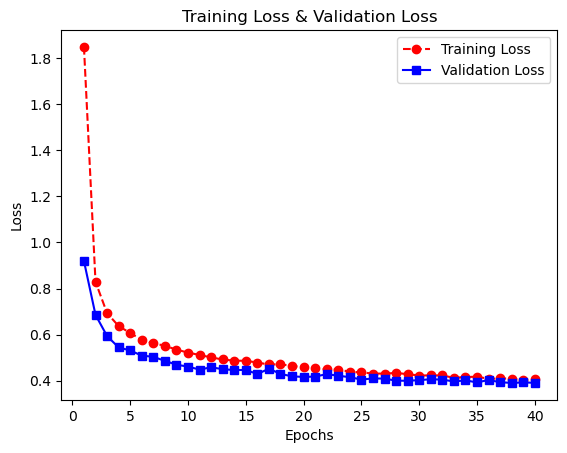

In [43]:
plot_loss(result_3.history['loss'],result_3.history['val_loss'])

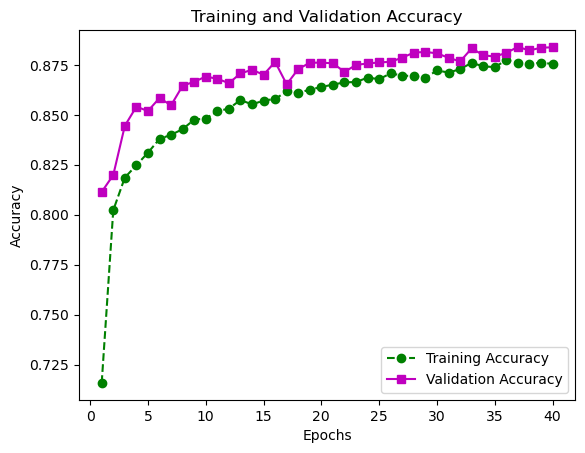

In [44]:
plot_accuracy(result_3.history['accuracy'],result_3.history['val_accuracy'])

In [45]:
test_loss,test_acc=model_3.evaluate(X_val,y_val)

438/438 [==============================] - 1s 1ms/step - loss: 0.3902 - accuracy: 0.8838


### We can now perform the training on the complete set now that we have the best model.

In [46]:
# Define an empty network
best_model = tf.keras.models.Sequential()

# adding 2 layers
best_model .add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28*28,)))
best_model .add(tf.keras.layers.Dropout(0.7))
best_model .add(tf.keras.layers.Dense(124, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
best_model .add(tf.keras.layers.Dense(46, activation='relu'))
best_model .add(tf.keras.layers.Dense(10, activation='softmax'))

In [47]:
best_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [48]:
best_result = best_model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/40
329/329 [==============================] - 3s 8ms/step - loss: 1.8655 - accuracy: 0.7286 - val_loss: 0.9263 - val_accuracy: 0.8131
Epoch 2/40
329/329 [==============================] - 2s 7ms/step - loss: 0.8296 - accuracy: 0.8037 - val_loss: 0.6655 - val_accuracy: 0.8374
Epoch 3/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6908 - accuracy: 0.8192 - val_loss: 0.5855 - val_accuracy: 0.8452
Epoch 4/40
329/329 [==============================] - 2s 7ms/step - loss: 0.6343 - accuracy: 0.8276 - val_loss: 0.5548 - val_accuracy: 0.8497
Epoch 5/40
329/329 [==============================] - 2s 7ms/step - loss: 0.5996 - accuracy: 0.8344 - val_loss: 0.5304 - val_accuracy: 0.8570
Epoch 6/40
329/329 [==============================] - 2s 7ms/step - loss: 0.5783 - accuracy: 0.8369 - val_loss: 0.5039 - val_accuracy: 0.8613
Epoch 7/40
329/329 [==============================] - 2s 7ms/step - loss: 0.5595 - accuracy: 0.8404 - val_loss: 0.4960 - val_accuracy: 0.8624
Epoch 

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score,cohen_kappa_score

# Get the predicted probabilities for the validation set
y_pred_prob = best_model.predict(X_val)

# Get the predicted classes for the validation set
Y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true classes for the validation set
y_true = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true,Y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, Y_pred, average='weighted')
recall = recall_score(y_true, Y_pred, average='weighted')
f1 = f1_score(y_true, Y_pred, average='weighted')

# Calculate Cohen's kappa 
kappa = cohen_kappa_score(y_true, Y_pred)

# Print the metrics
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Cohen kappa:', kappa)

438/438 [==============================] - 1s 1ms/step
Precision: 0.8874355379874063
Recall: 0.8873571428571428
F1-score: 0.8865313198975455
Cohen kappa: 0.8748387808075004


# Heatmap visualisation

### The confusion matrix derived from the model's predictions on the validation set will be visualized in this section using a heatmap. Between true class and expected class, the confusion matrix shows the proportion of accurate and inaccurate model predictions. Diagonal cells represent true positive predictions (accurate forecasts), whereas off-diagonal cells reflect false positive and false negative predictions (incorrect predictions).

### The heatmap format makes it easier to comprehend the confusion matrix by using color coding to highlight the number of guesses in each cell. The number of forecasts is represented by the color map "RdPu," with darker hues denoting more predictions.

Text(95.72222222222221, 0.5, 'Actual')

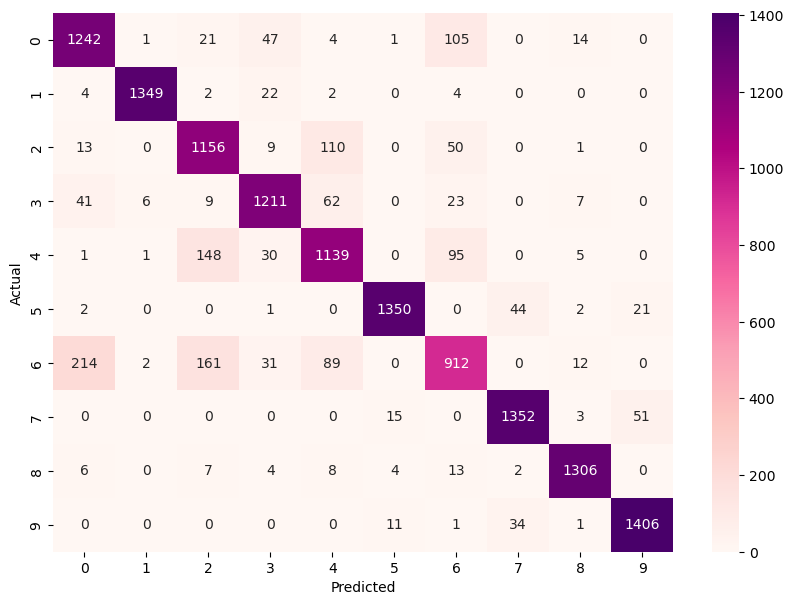

In [51]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Analysis

### We are able to infer from the evaluation metrics above that the model has a accuracy results of 88.79%, which seems to be performly relatively well. 

# Conclusion

### In conclusion, we are able to successfully train the model of the Fashion-MNIST dataset that is able to perform quite well. To build the model, we used evaluation method such as hold-out validation by regularising the model with drop-out and regularisation. 

### The model had a validation set accuracy of 88.79% and was trained using the Adam optimizer and categorical cross-entropy loss function.

### To evaluate the effectiveness of the model, we also computed metrics including precision, recall, F1-score, and Cohen's kappa coefficient. The performance of the model was visualized and the most typical errors were determined using the confusion matrix and error analysis.

### In conclusion, despite the differences in evaluation protocols, the models produced generally satisfactory outcomes with similar performance. It is crucial to remember that data splitting during hold-out validation may have an impact on the outcomes, and there might be a model that is better suited for iterated k-fold validation. Nevertheless, the models showed promise for correctly categorizing the Fashion-MNIST dataset.

# References

### Hold-out Method for Training Machine Learning Models https://vitalflux.com/hold-out-method-for-training-machine-learning-model/ 

### How to Use Weight Decay to Reduce Overfitting of Neural Network in Keras https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

### An Overview of Regularization Techniques in Deep Learning (with Python code) https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

### Model Evaluation Metrics in Machine Learning  https://www.kdnuggets.com/2020/05/model-evaluation-metrics-machine-learning.html